In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Creating delivary locations

In [39]:
def create_delivary(x,y,n):
    x_range = [x[0], y[0]]
    y_range = [x[1], y[1]]
    loc = []

    for i in range(n):
        x_loc = random.uniform(x_range[0], x_range[1])
        y_loc = random.uniform(y_range[0], y_range[1])
        loc.append([x_loc, y_loc])

    return loc

## Visualizations

In [40]:
def primary_plot(delivary_loc, obstacles):
    delivary_loc = np.array(delivary_loc)
    plt.scatter(delivary_loc[:,0], delivary_loc[:,1], label="Delivary loc")

    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    # plt.legend()

In [41]:
def plot_dp(dp, delivary_loc, obstacles):
    primary_plot(delivary_loc, obstacles)
    plt.scatter(dp[0], dp[1], marker='^', c="black", label = "DP")
    # plt.legend()
    # plt.show()

In [42]:
def plot_initial_route(dp, delivary_loc, obstacles, route):
    plot_dp(dp, delivary_loc, obstacles)
    for i in range(len(route)-1):
        f_pt = np.array([route[i][0], route[i+1][0]])
        s_pt = np.array([route[i][1], route[i+1][1]])
        plt.plot(f_pt, s_pt, c="gray")

## Calculate DP

In [43]:
def calculate_dp(delivary_loc):
    x = [i for i,j in delivary_loc]
    y = [j for i,j in delivary_loc]

    x_axis = np.mean(x)
    y_axis = np.mean(y)

    return [x_axis, y_axis]

## Create Route

In [44]:
def create_route(pts, extra):
    idx = 0
    k = len(pts)
    for i in range(k):
        pts.insert(idx, extra)
        idx +=2

    return pts

## Distance Calculate

In [45]:
def euc_distance(pt1, pt2):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.sqrt(np.sum((pt2 - pt1)**2))

In [46]:
def total_dist(pts):
    sum = 0
    for i in range(len(pts)-1):
        sum += euc_distance(pts[i], pts[i+1])

    return sum

## Check for obstacles

In [47]:
def check_obstacle(route):
    for i in range(len(route)-1,2):
        print(route[i],"->",route[i+1])

## Main

In [48]:
# pre-assumptions
x = [22.21, 88.45]
y = [32.45, 98.67]
n = 5

# answers
optimal_dp = []
optimal_route = []

# Creating delivary points
delivary_loc = create_delivary(x,y,n)

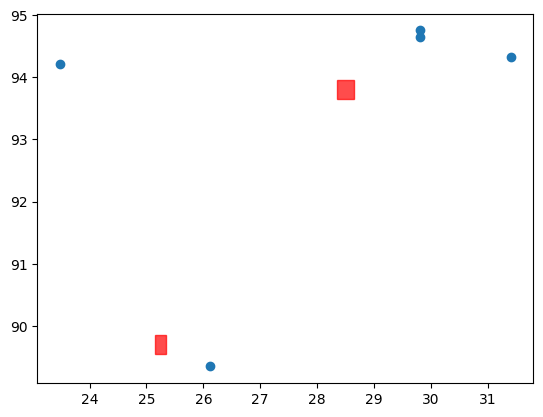

In [49]:
# creating obstacles
obstacles = {
    0 : [[28.35, 93.65],[28.65, 93.95]],
    1 : [[25.15, 89.55],[25.35, 89.85]]
}

primary_plot(delivary_loc, obstacles)

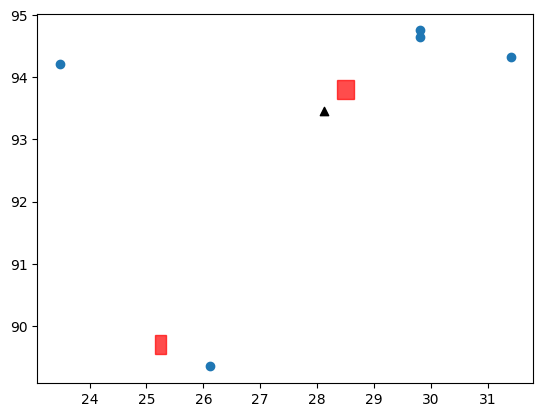

In [50]:
# creating initial dp
initial_dp = calculate_dp(delivary_loc)

# visualize dp
plot_dp(initial_dp, delivary_loc, obstacles)

*calculate total distance from the initial dp*

In [51]:
# calculate route
initial_route = create_route(delivary_loc,initial_dp)

for i in initial_route:
    print(i,"->",end=" ")
print("End")

[28.127012072977045, 93.45984656836987] -> [26.11622706410857, 89.34727066651446] -> [28.127012072977045, 93.45984656836987] -> [29.810790031432365, 94.75334794651202] -> [28.127012072977045, 93.45984656836987] -> [29.818811545294547, 94.65435434803385] -> [28.127012072977045, 93.45984656836987] -> [31.41017776535918, 94.33065425461623] -> [28.127012072977045, 93.45984656836987] -> [23.479053958690553, 94.21360562617275] -> End


Optimal Distance : 29.04624282521999


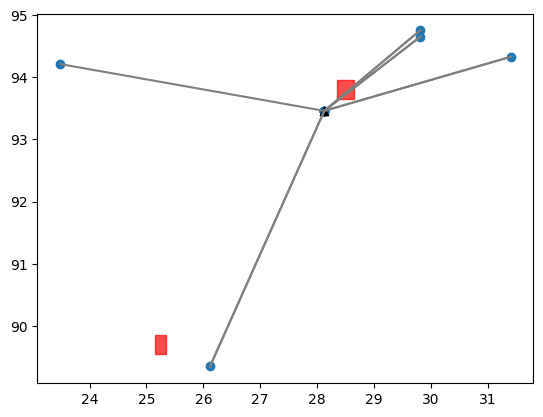

In [52]:
# calculating distance
initial_dist = total_dist(initial_route)

print("Optimal Distance :",initial_dist)

# Visualization
plot_initial_route(initial_dp, delivary_loc, obstacles, initial_route)

*check for obstacles in the path, if no obstacle then it is optimal dp and optimal path*

In [53]:
from shapely.geometry import LineString, Polygon

def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle_id, points in obstacles.items():
    pt1 = points[0]
    pt2 = points[1]
    coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
    obstacle = Polygon(coord)
    if line.intersects(obstacle):
      return True

  return False

In [54]:
def detect_obstacle(route, obstacles):
    for i in range(0,len(route)-1,2):
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            return True
    return False

In [56]:
if(detect_obstacle(initial_route, obstacles)):
    #  change the route to avoid obstacle
    #  if new distance is below the threshold value then its optimal
    #  Otherwise calculate another dp that will contain no obstacle

    print("Its not the optimal solution")
else:
    optimal_dp = initial_dp
    optimal_route = initial_route

print("Optimal dp :",optimal_dp)
print("Optimal route :",optimal_route)

Its not the optimal solution
Optimal dp : []
Optimal route : []
